In [1]:
import collections
import networkx as nx
import numpy as np
import os
import random
from sklearn import linear_model
import json as json

In [2]:
# plot settings
import matplotlib.pyplot as plt

FIGSIZE_TWOCOL = (9,4)
FIGSIZE_ONECOL = (5,4)

SMALL_SIZE = 13
MEDIUM_SIZE = 15
BIGGER_SIZE = 20

plt.rc('font', size= MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize= MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize= MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title


# Statistiche generali

In [3]:
g = nx.read_edgelist('../network/networks/edge_list.txt',
                     create_using=nx.DiGraph(), nodetype=int, data=False)

In [4]:
# network undirected
g_und = g.to_undirected()

In [5]:
# generating or loading an undirected Barabasi-Albert random network
if os.path.isfile('../network/networks/ba_edge_list.txt'):
    g_ba = nx.read_edgelist('../network/networks/ba_edge_list.txt',
                            create_using=nx.Graph(), nodetype=int,
                            data=False)
else:
    g_ba = nx.barabasi_albert_graph( g.number_of_nodes(), int(np.mean( list(d for n, d in g.degree()) )/2) )
    nx.write_edgelist(g_ba, '../network/networks/ba_edge_list.txt')


In [6]:
# generating or loading a directed Erdos-Renyi random network
if os.path.isfile('../network/networks/er_edge_list.txt'):
    g_er = nx.read_edgelist('../network/networks/er_edge_list.txt',
                            create_using=nx.DiGraph(), nodetype=int,
                            data=False)
else:
    g_er = nx.erdos_renyi_graph(g.number_of_nodes(), 0.001, directed=True)
    nx.write_edgelist(g_er, '../network/networks/er_edge_list.txt',
                      data=False)

In [7]:
def network_summary(g, directed=True):
    """ returns dictionary with the network informations"""
        
    g_info= {}
    g_info['N'] = nx.number_of_nodes(g)
    g_info['L'] = nx.number_of_edges(g)
    g_info['density'] = round(nx.density(g),5)
    
    if(directed):
        in_degrees = [d for n, d in g.in_degree()]
        out_degrees = [d for n, d in g.out_degree()]
        degrees = [d for n,d in g.degree()]
        g_info['k_avg'] = int(np.mean(in_degrees))
        g_info['k_in_max'] = np.max(in_degrees)
        g_info['k_in_min'] = np.min(in_degrees)
        g_info['k_out_max'] = np.max(out_degrees)
        g_info['k_out_min'] = np.min(out_degrees)
        g_info['k_max'] = np.max(degrees)
        g_info['k_min'] = np.min(degrees)
    else:
        degrees = [d for n,d in g.degree()]
        g_info['k_avg'] = int(np.mean(degrees))
        g_info['k_max'] = np.max(degrees)
        g_info['k_min'] = np.min(degrees)
        
    return g_info

In [8]:
g_info = network_summary(g, directed = True)
g_info

{'L': 2501757,
 'N': 65729,
 'density': 0.00058,
 'k_avg': 38,
 'k_in_max': 19064,
 'k_in_min': 0,
 'k_max': 19073,
 'k_min': 1,
 'k_out_max': 4130,
 'k_out_min': 0}

In [9]:
g_und_info = network_summary(g_und, directed = False)

In [11]:
g_er_info = network_summary(g_er, directed = True)
g_ba_info = network_summary(g_ba , directed = False)
g_ba_info

{'L': 2496258,
 'N': 65729,
 'density': 0.00116,
 'k_avg': 75,
 'k_max': 2890,
 'k_min': 38}

# Degree distribution

In [12]:
in_degrees = [d for n, d in g.in_degree()]
out_degrees = [d for n, d in g.out_degree()]
degrees =[d for n,d in g.degree()]
# ordinamento
in_degrees.sort(reverse=True)
out_degrees.sort(reverse=True)
degrees.sort(reverse=True)

## Logarithmic binning

In [13]:
def log_binning(degrees, b=2, prob=True, split = False):
    """
    computing the degree distribution using log binning
    input:
    - degrees: list of the degrees
    - b=2: base step for the bins
    - prob=True, return the probabilities
    output:
    - degree_means
    - degree_probs
    if(prob=False) returns the counts 

    Example:
    degrees=list(range(16))
    means,probs= log_binning(degrees)
    print means
    print probs
    """
    degrees = [d for d in degrees if d>0]

    """ computing breaks """
    k=0
    breaks=[]
    while(b**(k-1)< max(degrees)):
        breaks.append(b**k)
        k+=1
    breaks.append(b**k)

    # splitting the degrees using the breaks
    splitted_degrees = {}
    for br in breaks:
        splitted_degrees[br]=[]

    for d in degrees:
        i=1
        #  print d
        while(d>=breaks[i]):
            i+=1
        splitted_degrees[breaks[i-1]].append(d)  

    # counting for each bin
    d_counts = {}
    for br in breaks:
        d_counts[br]=[]

    for br in breaks:
        d_counts[br] = len(splitted_degrees[br])

    counts = [d_counts[br] for br in breaks]

    # computing probabilities
    degree_probs = np.array(counts).astype(float)/(np.array(breaks)) 
    # normalization of the probabilities
    degree_probs= (degree_probs.astype(float))/sum(degree_probs)

    degree_means = [ np.mean(np.array(splitted_degrees[br])) for br in breaks ]
    if(split):
        return splitted_degrees
    
    if(prob):
        return degree_means, degree_probs
    else:
        return degree_means, counts

In [14]:
help(log_binning)

Help on function log_binning in module __main__:

log_binning(degrees, b=2, prob=True, split=False)
    computing the degree distribution using log binning
    input:
    - degrees: list of the degrees
    - b=2: base step for the bins
    - prob=True, return the probabilities
    output:
    - degree_means
    - degree_probs
    if(prob=False) returns the counts 
    
    Example:
    degrees=list(range(16))
    means,probs= log_binning(degrees)
    print means
    print probs



In [15]:
degrees=list(range(16))
means,probs= log_binning(degrees, split=False)
print means
print probs
splitted= log_binning(degrees, split=True)
print splitted

[1.0, 2.5, 5.5, 11.5, nan, nan]
[ 0.25  0.25  0.25  0.25  0.    0.  ]
{32: [], 1: [1], 2: [2, 3], 4: [4, 5, 6, 7], 8: [8, 9, 10, 11, 12, 13, 14, 15], 16: []}


/home/stefano/Py-envs/dm-py2/local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/stefano/Py-envs/dm-py2/local/lib/python2.7/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [25]:
# total degree
degree_counts = collections.Counter(d for d in degrees)
degree_counts = [degree_counts.get(i, 0) for i in range(max(degree_counts) + 1) ] #if degree_counts.get(i,0)>0]
degree= np.arange(len(degree_counts))
degree_probs = np.array(degree_counts).astype(float)/len(degrees)

In [17]:
# out degree
out_degrees =[d for n,d in g.out_degree()]
out_degree_counts = collections.Counter(d for n, d in g.out_degree())
out_degree_counts = [out_degree_counts.get(i, 0) for i in range(max(out_degree_counts) + 1)]
degree_out= np.arange(len(out_degree_counts))
out_degree_probs = np.array(out_degree_counts).astype(float)/g_info['N']

In [18]:
# in degree
in_degree_counts = collections.Counter(d for n, d in g.in_degree())
in_degree_counts = [in_degree_counts.get(i, 0) for i in range(max(in_degree_counts) + 1)]
degree_in= np.arange(len(in_degree_counts))
in_degree_probs = np.array(in_degree_counts).astype(float)/g_info['N']

In [19]:
# Erdos-Renyi degree
er_degree_counts = collections.Counter(d for n, d in g_er.degree())
er_degree_counts = [er_degree_counts.get(i, 0) for i in range(max(er_degree_counts) + 1)]
er_degree= np.arange(len(er_degree_counts))
er_degree_probs = np.array(er_degree_counts).astype(float)/g_info['N']

In [20]:
# Barabasi-Albert degree
ba_degree_counts = collections.Counter(d for n, d in g_ba.degree())
ba_degree_counts = [ba_degree_counts.get(i, 0) for i in range(max(ba_degree_counts) + 1) ]
ba_degree= np.arange(len(ba_degree_counts))
ba_degree_probs = np.array(ba_degree_counts).astype(float)/g_ba.number_of_nodes()

In [21]:
# proability distributions with log binning
# tot degree
prob = True
degrees =[d for n,d in g.degree()]
degree_means, degree_log_probs = log_binning(degrees, prob =prob)
# in-degree
in_degrees =[d for n,d in g.in_degree()]
in_degree_means, in_degree_log_probs = log_binning(in_degrees, prob =prob)
# out-degree
out_degrees =[d for n,d in g.out_degree()]
out_degree_means, out_degree_log_probs = log_binning(out_degrees , prob =prob)
#ER-degree
er_degrees =[d for n,d in g_er.degree()]
er_degree_means, er_degree_log_probs = log_binning(er_degrees, prob =prob)
#BA-degree
ba_degrees =[d for n,d in g_ba.degree()]
ba_degree_means, ba_degree_log_probs = log_binning(ba_degrees, prob = prob)

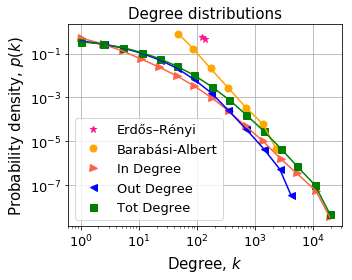

In [22]:
fig, ax = plt.subplots(figsize=FIGSIZE_ONECOL)
MARKERSIZE= 7

# random networks
plt.plot(er_degree_means, er_degree_log_probs, '*', color='deeppink',   label=u'Erdős–Rényi', markersize = MARKERSIZE)
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label=u'Barabási-Albert', markersize = MARKERSIZE)
# real network
plt.plot(in_degree_means, in_degree_log_probs, '>', color='tomato',   label='In Degree', markersize = MARKERSIZE)
plt.plot(out_degree_means, out_degree_log_probs, '<', color='blue',   label='Out Degree', markersize = MARKERSIZE)
plt.plot(degree_means, degree_log_probs, 's', color='green',   label='Tot Degree', markersize = MARKERSIZE)

plt.plot(er_degree_means, er_degree_log_probs, '-', color='deeppink')
plt.plot(ba_degree_means, ba_degree_log_probs, '-', color='orange')
# real network
plt.plot(in_degree_means, in_degree_log_probs, '-', color='tomato')
plt.plot(out_degree_means, out_degree_log_probs, '-', color='blue')
plt.plot(degree_means, degree_log_probs, '-', color='green')

plt.grid()
plt.title("Degree distributions")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                                     
plt.loglog()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/degree_distributions.pdf")                                     

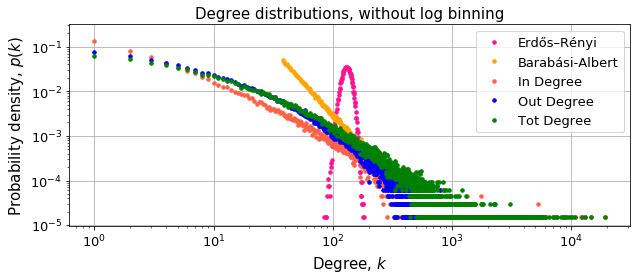

In [26]:
fig, ax = plt.subplots(figsize=FIGSIZE_TWOCOL)
MARKERSIZE= 7

# random networks
plt.plot(er_degree, er_degree_probs, '.', color='deeppink',   label=u'Erdős–Rényi', markersize = MARKERSIZE)
plt.plot(ba_degree, ba_degree_probs, '.', color='orange',   label=u'Barabási-Albert', markersize = MARKERSIZE)
# real network
plt.plot(degree_in, in_degree_probs, '.', color='tomato',   label='In Degree', markersize = MARKERSIZE)
plt.plot(degree_out, out_degree_probs, '.', color='blue',   label='Out Degree', markersize = MARKERSIZE)
plt.plot(degree, degree_probs, '.', color='green',   label='Tot Degree', markersize = MARKERSIZE)

plt.grid()
plt.title("Degree distributions, without log binning")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                                     
plt.loglog()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/degree_distributions_nobinlog.pdf")                                     

In [27]:
# regression testing
begin = 30
end = 200
counts_Y = np.log(in_degree_probs[begin:end])
degree_X = np.log(degree_in[begin:end]).astype(float)
degree_X=degree_X.reshape(end-begin,1)
regr = linear_model.LinearRegression()
regr.fit(degree_X, counts_Y)
count_pred = regr.predict(degree_X)+0.5

In [28]:
print regr.coef_[0]
print regr.intercept_
print regr.score(degree_X, counts_Y)

-1.64533850716
0.285776511621
0.95378108165


In [29]:
def regression(degree, degree_probs, begin, end, h_adjust=-0, color= "black"):
    """regression analysis between begin and end, 
    plotting of the line and returns the slope"""
    counts_Y = np.log(degree_probs[begin:end])
    degree_X = np.log(degree[begin:end]).astype(float)
    degree_X=degree_X.reshape(end-begin,1)
    regr = linear_model.LinearRegression()
    regr.fit(degree_X, counts_Y)
    count_pred = regr.predict(degree_X)+h_adjust
    plt.plot( np.exp(degree_X), np.exp(count_pred), color= color)
    return -regr.coef_[0]

## In-degree distribution

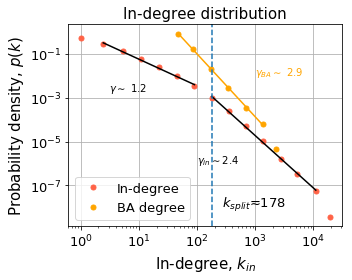

In [30]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(in_degree_means, in_degree_log_probs, 'o', color='tomato',   label='In-degree', markersize = 5)
##plt.plot(degree_out, out_degree_probs, '.', color='green',   label='Original')

# barabasi
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label='BA degree', markersize = 5)
gamma_ba = regression(ba_degree_means, ba_degree_log_probs, 5, 11, color='orange').round(1)
plt.text(1000,float(1)/100, "$\gamma_{BA}\sim $"+" {}".format(gamma_ba), color = 'orange')


split = 7
gamma_in_1 = regression(in_degree_means, in_degree_log_probs, 1,split).round(1)
gamma_in_2 = regression(in_degree_means, in_degree_log_probs, split, 14).round(1)

plt.text(3, (float(1)/500), "$\gamma \sim $ {}".format(gamma_in_1))
plt.text(100,float(1)/1000000, "$\gamma_{in} \sim $"+"{}".format(gamma_in_2))
# plt.text(1,float(1)/10**7, "$p(k) \sim k^{-\gamma}  $ ",fontsize =15)
# info on the splitting

in_degree_split = in_degree_means[split].round(0)
plt.axvline(in_degree_split, 0,1000, linestyle='--')
plt.text(1.5*in_degree_split, float(1)/10**8, "$k_{split} \eqsim$"+"{:.0f}".format(in_degree_split), fontsize=SMALL_SIZE)

plt.title("In-degree distribution")
plt.xlabel("In-degree, $k_{in}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.legend(loc =3)
plt.tight_layout()
plt.savefig("imgs/in_degree_distribution.pdf")                                     

## Out-degree distribution

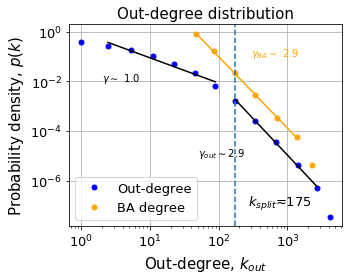

In [31]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(out_degree_means, out_degree_log_probs, 'o', color='blue',   label='Out-degree', markersize = 5)

# barabasi
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label='BA degree', markersize = 5)
gamma_ba = regression(ba_degree_means, ba_degree_log_probs, 5, 11, color='orange').round(1)
plt.text(300,float(1)/10, "$\gamma_{BA}\sim $"+" {}".format(gamma_ba), color = 'orange')

split = 7
gamma_out_1 = regression(out_degree_means, out_degree_log_probs, 1,split).round(1)
gamma_out_2 = regression(out_degree_means, out_degree_log_probs, split, 12).round(1)

plt.text(2, (float(1)/100), "$\gamma \sim $ {}".format(gamma_out_1))
plt.text(50,float(1)/100000, "$\gamma_{out} \sim $"+ "{}".format(gamma_out_2))
#plt.text(1,float(1)/10**6, "$p(k) \sim k^{-\gamma}  $ ",fontsize =15)
# info on the splitting

out_degree_split = out_degree_means[split].round(0)
plt.axvline(out_degree_split, 0,1000, linestyle='--')
plt.text(1.5*out_degree_split, float(1)/10**7, "$k_{split} \eqsim$"+"{:.0f}".format(out_degree_split), fontsize=SMALL_SIZE)

plt.title("Out-degree distribution")
plt.xlabel("Out-degree, $k_{out}$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/out_degree_distribution.pdf")                                     

# Tot degree 

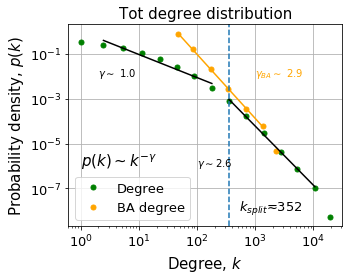

In [32]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(degree_means, degree_log_probs, 'o', color='green',   label='Degree', markersize = 5)

# barabasi
plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label='BA degree', markersize = 5)
gamma_ba = regression(ba_degree_means, ba_degree_log_probs, 5, 11, color='orange').round(1)
plt.text(1000,float(1)/100, "$\gamma_{BA}\sim $"+" {}".format(gamma_ba), color = 'orange')

split = 8
gamma_1 = regression(degree_means, degree_log_probs, 1,split).round(1)
gamma_2 = regression(degree_means, degree_log_probs, split, 14).round(1)

plt.text(2, (float(1)/100), "$\gamma \sim $ {}".format(gamma_1))
plt.text(100,float(1)/1000000, "$\gamma \sim $"+ "{}".format(gamma_2))
plt.text(1,float(1)/10**6, "$p(k) \sim k^{-\gamma}  $ ",fontsize =15)
# info on the splitting

degree_split = degree_means[split].round(0)
plt.axvline(degree_split, 0,1000, linestyle='--')
plt.text(1.5*degree_split, float(1)/10**8, "$k_{split} \eqsim$"+"{:.0f}".format(degree_split), fontsize=SMALL_SIZE)

plt.title("Tot degree distribution")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/tot_degree_distribution.pdf")                                     

In [33]:
g_info['gamma_in'] = round(gamma_in_2,1)
g_info['gamma_out'] = round(gamma_out_2,1)
g_info['gamma'] = round(gamma_2,1)
g_ba_info['gamma'] = round(gamma_ba,1)

# Connected components

In [34]:
print nx.is_strongly_connected(g)
print nx.is_weakly_connected(g)
print nx.is_strongly_connected(g_er)
print nx.is_weakly_connected(g_er)
print nx.is_connected(g_ba)

False


False


True


True
True


In [35]:
print nx.number_strongly_connected_components(g)
print nx.number_weakly_connected_components(g)

15757


62


In [36]:
g_weak = collections.Counter(len(c)
                                 for c in nx.weakly_connected_components(g))
g_strong = collections.Counter(
        len(c)for c in nx.strongly_connected_components(g)
    )
er_weak = collections.Counter(len(c) for c in nx.
                                  weakly_connected_components(g_er))
er_strong = collections.Counter(len(c) for c in nx.
                                    strongly_connected_components(g_er))

In [37]:
x_weak = list(np.union1d(g_weak.keys(), er_weak.keys()))
x_strong = list(np.union1d(g_strong.keys(), er_strong.keys()))
y_weak = [g_weak[k] if k in g_weak else 0 for k in x_weak]
y_strong = [g_strong[k] if k in g_strong else 0 for k in x_strong]
y_weak_er = [er_weak[k] if k in er_weak else 0 for k in x_weak]

import copy
y_weak_lab = copy.copy(y_weak)
y_weak_lab[-1] =1

y_strong_lab = copy.copy(y_strong)
y_strong_lab[-1] =1


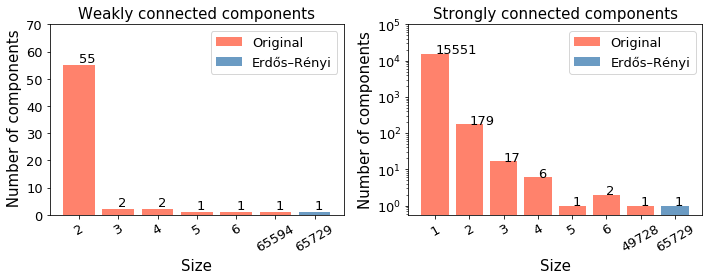

In [38]:
#plt.subplots(figsize = (10,10))
plt.subplots(figsize = (10,4))

plt.subplot(121)
plt.bar(range(len(x_weak)),y_weak,
            color='tomato', label='Original', alpha=.8)

for i in range(len(x_weak)):
    plt.text( i, y_weak_lab[i]+1, y_weak_lab[i] ,fontsize=SMALL_SIZE)

plt.bar(range(len(x_weak)), y_weak_er,
         color='steelblue', label=u'Erdős–Rényi', alpha=.8)
plt.xticks(range(len(x_weak)), x_weak, rotation = 30)
plt.title('Weakly connected components')
plt.xlabel('Size')
plt.ylabel(' Number of components')
plt.legend()
plt.ylim(ymax=70)

plt.subplot(122)
plt.bar(range(len(x_strong)),
        [g_strong[k] if k in g_strong else 0 for k in x_strong],
        color='tomato', label='Original', log=True, alpha=.8)
plt.bar(range(len(x_strong)),
        [er_strong[k] if k in er_strong else 0 for k in x_strong],
        color='steelblue', label=u'Erdős–Rényi', log=True, alpha=.8)
for i in range(len(x_strong)):
    plt.text( i, y_strong_lab[i], y_strong_lab[i] , fontsize=SMALL_SIZE)

plt.xticks(range(len(x_strong)), x_strong, rotation =30)
plt.title('Strongly connected components')
plt.xlabel('Size')
plt.ylabel('Number of components')
plt.legend()
plt.ylim(ymax = 10**5)

plt.subplots_adjust(left=0.125, right=0.9, bottom=0.1, top=1.4, wspace=0.2,
                    hspace=0.2)

plt.tight_layout()
plt.savefig('./imgs/connectivity.pdf', format='pdf')


# Path analysis

In [39]:
import datetime 
import time

In [40]:
g_und = g.to_undirected()

In [41]:
g_c = [g_und.subgraph(c) for c in nx.connected_components(g_und)]

In [42]:
largest_cc = g_c[0]
print len(largest_cc)


65594


In [43]:
import random
def sample_distances(g, n = 1000):
    """
    computes the shortest path lengths of a sample of n nodes of a graph g
    returns: list of distances computed
    """
    temp = g.nodes()
    nodes = [nd for nd in temp]
    distances = []
    for i in range(n):
        i1 = random.randint(0,len(nodes)-1)
        i2 = random.randint(0,len(nodes)-1)
        try:
            distances.append( nx.shortest_path_length(g, nodes[i1], nodes[i2]))
        except nx.NetworkXNoPath:
            continue
    print "avg distance: "+ str(np.mean(distances))
    return distances

## estimating computation time

In [44]:
n_pairs = [1000, 10000, 20000, 50000, 80000, 100000]

In [45]:
times= []
for L in n_pairs:
    start = datetime.datetime.now()
    distances = sample_distances(largest_cc,L)
    end = datetime.datetime.now()
    times.append( (end-start).seconds )

avg distance: 2.921


avg distance: 2.9221


avg distance: 2.9185


avg distance: 2.91986


avg distance: 2.9233


avg distance: 2.92118


In [46]:
print times

[0, 9, 20, 49, 79, 111]


In [48]:
# time regression 
n_max = (g_info['N'])*(g_info['N']-1)/2
Y = np.array(times)
X = np.array(n_pairs)
X=X.reshape(len(X),1)
regr = linear_model.LinearRegression()
regr.fit(X, Y)
X_pred = np.linspace(1000, n_max, num = 100000)
X_pred = X_pred.reshape(len(X_pred), 1)
times_pred = regr.predict(X_pred)
regr.coef_[0]

0.001081329605467537

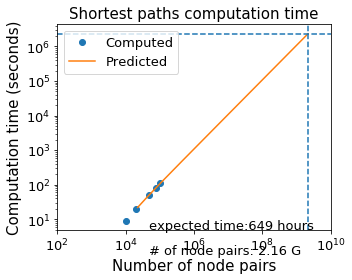

In [49]:
# computation time plot
plt.subplots(figsize=FIGSIZE_ONECOL)
plt.plot(n_pairs, times, 'o', label="Computed")
plt.plot(X_pred, times_pred, label="Predicted")
plt.axvline(n_max,0,100,linestyle='--')
plt.axhline(max(times_pred),0,100,linestyle='--')
plt.text(5*10**4, 5, "expected time:"+ "{:.0f} hours".format(max(times_pred)/3600),fontsize =SMALL_SIZE)
plt.text(5*10**4, 1, "# of node pairs: {:.2f} G".format( float(n_max)/(10**9)), fontsize = SMALL_SIZE)
plt.xlim(10**2,10**10)
plt.loglog()
plt.legend(loc='upper left')

plt.title("Shortest paths computation time")
plt.xlabel("Number of node pairs")
plt.ylabel("Computation time (seconds)")
plt.tight_layout()
#plt.yscale('log')
plt.savefig('./imgs/paths_computation_time.pdf', format='pdf')

In [50]:
# computing statistics
d_mean = np.mean(distances)
print d_mean
s=np.std(distances)
d_std= np.std(distances)/np.sqrt(len(distances))
print s
print d_std
print max(distances)

2.92118
0.670244289495
0.00211949854352
8


## average path length distribution

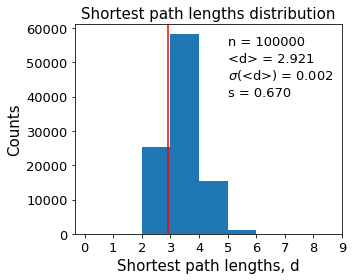

In [51]:
# average path length distribution
plt.subplots(figsize = FIGSIZE_ONECOL)
prova=plt.hist(distances,bins = np.arange(0,8))
plt.title("Shortest path lengths distribution")
plt.xlabel("Shortest path lengths, d")
plt.ylabel("Counts")
plt.tight_layout()
plt.xticks(np.arange(max(distances)+2))
plt.axvline(np.mean(distances), color="red")
plt.text(5,55000, "n = {:.0f}".format(len(distances)), fontsize = SMALL_SIZE)
plt.text(5,50000, "<d> = {:.3f}".format(d_mean), fontsize = SMALL_SIZE)
plt.text(5,45000, "$\sigma$"+"(<d>) = {:.3f}".format(d_std), fontsize =SMALL_SIZE)
plt.text(5,40000, "s = {:.3f}".format(s), fontsize = SMALL_SIZE)
plt.savefig('./imgs/paths_hist.pdf', format='pdf')


In [52]:
distances_g = sample_distances(g,1000)

avg distance: 3.6693877551


In [135]:
## Preserving degree random graph

In [136]:
temp = largest_cc.degree()
seq_degrees = [d for n,d in temp]
# random_g = nx.expected_degree_graph(seq_degrees, selfloops=False)
# nx.write_edgelist(random_g, '../network/networks/random_fixed_degree_edge_list.txt')

In [54]:
g_random = nx.read_edgelist('../network/networks/random_fixed_degree_edge_list.txt',
                     create_using=nx.Graph(), nodetype=int, data=False)

In [138]:
info_random_g = network_summary(g_random, directed =False)
info_g_cc = network_summary(largest_cc, directed =False)

In [55]:
distances_r = sample_distances(g_random, 100000)
distances_ba = sample_distances(g_ba, 100000)
distances_er = sample_distances(g_er, 100000)

avg distance: 2.86399551919


avg distance: 2.83379


avg distance: 2.95121


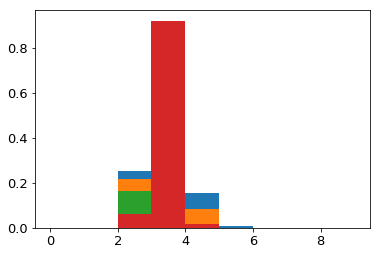

In [72]:
X = np.arange(10)
d_mean_random = np.mean(distances_r)
d_mean_ba = np.mean(distances_ba)
d_mean_er = np.mean(distances_er)

out = plt.hist(distances, bins= X,density =True)
out_r = plt.hist(distances_r, bins= X, density =True)
out_ba = plt.hist(distances_ba, bins= X, density =True)
out_er = plt.hist(distances_er, bins= X, density =True)

g_und_info['avg_d'] = d_mean
g_ba_info['avg_d'] = d_mean_ba
g_er_info['avg_d'] = d_mean_er


[0 1 2 3 4 5 6 7 8]


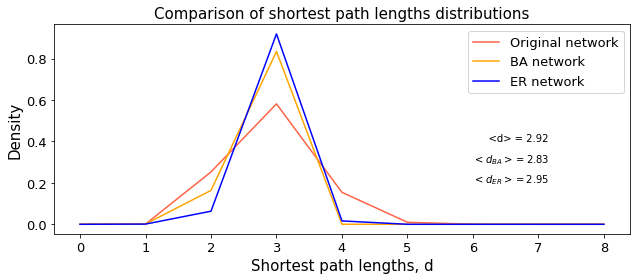

In [57]:
X=(out[1][:-1])
print (X)
plt.subplots(figsize = FIGSIZE_TWOCOL)
plt.plot(X, out[0], label = "Original network", color = "tomato")
#plt.plot(X, out_r[0], label = "Degree preserving \nrandom network", color = "blue")

plt.plot(X, out_ba[0], label = "BA network", color = "orange")
plt.plot(X, out_er[0], label = "ER network", color = "blue")

#plt.axvline(d_mean, color= "tomato")
#plt.axvline(d_mean_random, color= "blue")
plt.title("Comparison of shortest path lengths distributions")
plt.xlabel("Shortest path lengths, d")
plt.ylabel("Density")
plt.text(6,0.4, "     <d> = {:.2f}".format(d_mean))
plt.text(6,0.3, "$<d_{BA}> = $"+ "{:.2f}".format(d_mean_ba))
plt.text(6,0.2, "$<d_{ER}> = $"+ "{:.2f}".format(d_mean_er))
#plt.text(6,0.1, "$<d_{ER}> = $"+ "{:.3f}".format(d_mean_random))

plt.tight_layout()
plt.legend()
plt.savefig('./imgs/paths_hist_comparison.pdf', format='pdf')

# Clustering coefficient

In [58]:
import datetime
import time
import pandas as pd

In [59]:
temp = g.nodes()
nodes = [nd for nd in temp]

In [60]:
import random
def sample_cluster(g, n = 1000):
    """
    computes the clustering coefficient of a sample of n nodes of a graph g
    returns: list of clustering coefs computed
    """
    temp = g.nodes()
    nodes = [nd for nd in temp]
    clusters = []
    for i in range(n):
        i = random.randint(0,len(nodes)-1)
        try:
            clusters.append( nx.clustering(g, nodes[i]))
        except nx.NetworkXNoPath:
            continue
    print np.mean(clusters)
    return clusters

In [61]:
start = datetime.datetime.now()
clusters = nx.clustering(g_und, nodes)
end = datetime.datetime.now()

In [62]:
(end-start).seconds

753

In [28]:
#start = datetime.datetime.now()
#clusters = sample_cluster(g_und, n =10000)
#end = datetime.datetime.now()

In [63]:
degrees = { n:d for n,d in g_und.degree()}

In [64]:
clust = [clusters[nd] for nd in nodes]
deg = [degrees[nd] for nd in nodes]

In [65]:
df_clust = pd.DataFrame({'id':nodes, 'C': clust, 'degree' : deg})

In [66]:
df_clust.head()

          C  degree                  id
0  0.265353     384  780564694922690560
1  0.024803    2100  824797212425191425
2  0.253185     199  870705205267922946
3  0.357881     149  854450822985416707
4  0.406977     172  868153809603657732

In [75]:
C_mean = np.mean(clust)
C_std = np.std(clust)
C_mean_std = np.std(clust)/np.sqrt(len(clust))
g_und_info['C_mean'] = C_mean

In [76]:
g_und_info

{'C_mean': 0.25373082356161303,
 'L': 1895878,
 'N': 65729,
 'avg_d': 2.9211800000000001,
 'density': 0.00088,
 'k_avg': 57,
 'k_max': 19065,
 'k_min': 1}

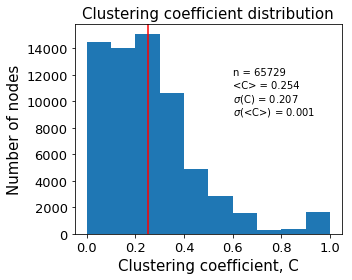

In [68]:
# clustering coef distribution
plt.subplots(figsize = FIGSIZE_ONECOL)
prova=plt.hist(clust)
plt.title("Clustering coefficient distribution")
plt.xlabel("Clustering coefficient, C")
plt.ylabel("Number of nodes")
plt.tight_layout()
#plt.xticks(np.arange(max(clust)+0.1))
plt.axvline(np.mean(clust), color="red")
xpos = 0.6
plt.text(xpos,12000, "n = {:.0f}".format(len(clust)))
plt.text(xpos,11000, "<C> = {:.3f}".format(C_mean))
plt.text(xpos,10000, "$\sigma$"+"(C) = {:.3f}".format(C_std))
plt.text(xpos,9000, "$\sigma$"+"(<C>) = {:.3f}".format(C_mean_std))
plt.savefig('./imgs/cluster_coef_hist.pdf', format='pdf')


In [73]:
g_und_info

{'L': 1895878,
 'N': 65729,
 'avg_d': 2.9211800000000001,
 'density': 0.00088,
 'k_avg': 57,
 'k_max': 19065,
 'k_min': 1}

0.0008671971276


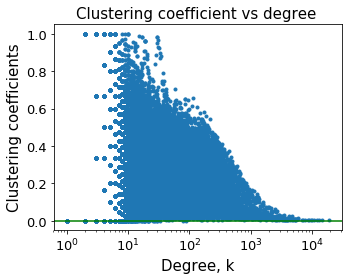

In [74]:
fig,ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(df_clust['degree'], df_clust['C'], '.')
C_mean_rand = float(g_und_info['k_avg'])/g_und_info['N']
print C_mean_rand
plt.axhline(C_mean_rand, color='green')
#plt.loglog()
plt.title('Clustering coefficient vs degree ')
plt.ylabel('Clustering coefficients')
plt.xlabel('Degree, k')
ax.set_xscale('log')
plt.tight_layout()
plt.savefig('./imgs/cluster_coef_bydegree.pdf', format='pdf')

In [225]:
start = datetime.datetime.now()
clusters_ba = nx.clustering(g_ba)
end = datetime.datetime.now()

In [226]:
(end-start).seconds

158

In [230]:
C_mean_ba = np.mean(clusters_ba.values())

In [232]:
g_ba_info['C_mean'] = C_mean_ba

In [233]:
start = datetime.datetime.now()
clusters_er = nx.clustering(g_er_und)
end = datetime.datetime.now()


In [ ]:
C_mean_ba = np.mean(clusters_ba.values())

In [235]:
C_mean_er = np.mean(clusters_er.values())
g_er_info['C_mean'] = C_mean_er

# Hubs

In [77]:
import pandas as pd
import datetime 
import time

In [78]:
hubs = { n:d for n,d in g_und.degree() if d>=1000}
hubs_ids = hubs.keys()
len(hubs_ids)

318

In [79]:
df_hubs= pd.DataFrame({'id':hubs_ids, 'degree': [ hubs[h] for h in hubs_ids] })

In [11]:
start = datetime.datetime.now()
clusters = nx.clustering(g_und, hubs_ids)
end = datetime.datetime.now()

In [12]:
(end-start).seconds

30

In [13]:
df_hubs['C'] = [clusters[h] for h in hubs_ids]

In [14]:
df_hubs.head()

   degree                  id         C
0    1325  811972460560019456  0.009867
1    2100  824797212425191425  0.024803
2    1018            19038210  0.142939
3    1758           633287684  0.042920
4    1587  845833560611340293  0.101011

In [15]:
df_hubs = df_hubs.sort_values('degree', ascending=False)
df_hubs.shape[0]*2/60

10

In [125]:
start = datetime.datetime.now()
closeness = [nx.closeness_centrality(g_und, df_hubs['id'][i]) for i in range(df_hubs.shape[0])]
end = datetime.datetime.now()
print (end-start).seconds 

705


In [16]:
705/60

11

In [17]:
df_hubs['cc'] = closeness

NameError: name 'closeness' is not defined

In [155]:
temp = g.in_degree()
in_degree = {n:d for n,d in temp}
df_hubs['in_degree'] = [in_degree[h] for h in df_hubs['id']]

In [161]:
temp = g.out_degree()
out_degree = {n:d for n,d in temp}
df_hubs['out_degree'] = [out_degree[h] for h in df_hubs['id']]

In [162]:
df_hubs.head()

     degree        id         C        cc  in_degree  out_degree
73    19065    807095  0.002633  0.417001      19064           9
204   14637   1652541  0.003601  0.510699      14629          47
277   13144   2467791  0.004233  0.440488      13129          56
1     12217  87818409  0.004283  0.434341      12200          54
141   10752    816653  0.002871  0.459824      10744          29

In [163]:
df_hubs.to_csv('hubs.csv')

In [164]:
df_hubs.describe()

             degree            id           C          cc     in_degree  \
count    318.000000  3.180000e+02  318.000000  318.000000    318.000000   
mean    2243.830189  5.006157e+16    0.036563    0.422167   2100.584906   
std     2104.874429  1.939271e+17    0.032751    0.031432   2135.839286   
min     1007.000000  7.670000e+02    0.002633    0.345926     86.000000   
25%     1178.500000  1.595169e+07    0.014360    0.401798   1094.250000   
50%     1489.000000  3.576536e+07    0.025866    0.421554   1389.000000   
75%     2446.250000  3.074657e+08    0.046403    0.442363   2171.500000   
max    19065.000000  8.772278e+17    0.166554    0.549705  19064.000000   

        out_degree  
count   318.000000  
mean    586.842767  
std     783.172276  
min       0.000000  
25%      26.250000  
50%     137.500000  
75%    1033.250000  
max    4130.000000  

# Triangles

In [170]:
start = datetime.datetime.now()
triangles = nx.triangles(g_und)
end = datetime.datetime.now()
print (end-start).seconds 

726


In [183]:
Tlist = (triangles.values())
T = (sum(Tlist))/3

In [184]:
g_und_info['T'] = T

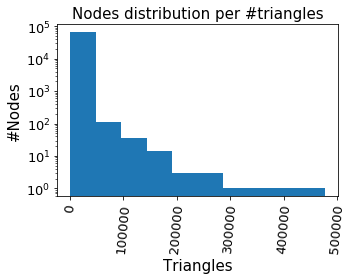

In [195]:
plt.subplots(figsize = FIGSIZE_ONECOL)
plt.hist(sorted(triangles.values()), log=True)
plt.title('Nodes distribution per #triangles')
plt.xlabel('Triangles')
plt.ylabel('#Nodes')
plt.xticks(rotation=85)
plt.tight_layout()
plt.savefig('./imgs/triangles_tot.pdf', format='pdf')




In [206]:
start = datetime.datetime.now()
#triangles = nx.triangles(g_undnodes[r] for r in randoms]))
triangles_ba = nx.triangles(g_ba)
end = datetime.datetime.now()
print (end-start).seconds 

150


In [207]:
triangles_ba

In [209]:
Tlist = (triangles_ba.values())
T_ba = (sum(Tlist))/3
g_ba_info['T'] = T_ba

{'L': 2496258,
 'N': 65729,
 'T': 996837,
 'avg_d': 2.83379,
 'density': 0.00116,
 'gamma': 2.9,
 'k_avg': 75,
 'k_max': 2890,
 'k_min': 38}

In [212]:
g_er_und = g_er.to_undirected()

In [213]:
start = datetime.datetime.now()
triangles_er = nx.triangles(g_er_und)
end = datetime.datetime.now()
print (end-start).seconds 

229


In [216]:
Tlist = (triangles_er.values())
T_er = (sum(Tlist))/3
g_er_info['T'] = T_er

{'L': 4318406,
 'N': 65729,
 'T': 376972,
 'avg_d': 2.9512100000000001,
 'density': 0.001,
 'k_avg': 65,
 'k_in_max': 109,
 'k_in_min': 36,
 'k_max': 183,
 'k_min': 84,
 'k_out_max': 103,
 'k_out_min': 35}

# Italian subnetwork

In [136]:
g_ita = nx.read_edgelist('../network/networks/g_ita_edge_list.txt',
                     create_using=nx.DiGraph(), nodetype=int, data=False)

In [137]:
g_ita_und = g_ita.to_undirected()

In [139]:
g_ita_info = network_summary(g_ita, directed = True)
g_ita_und_info = network_summary(g_ita_und, directed =False)

In [225]:
g_ita_info['N']*(g_ita_info['N']-1)/2

2706301

In [140]:
# proability distributions with log binning
# tot degree
prob = True
ita_degrees =[d for n,d in g_ita.degree()]
ita_degree_means, ita_degree_log_probs = log_binning(ita_degrees, prob =prob)

In [141]:
# in-degree
in_degrees =[d for n,d in g.in_degree()]
in_degree_means, in_degree_log_probs = log_binning(in_degrees, prob =prob)
# out-degree
out_degrees =[d for n,d in g.out_degree()]
out_degree_means, out_degree_log_probs = log_binning(out_degrees , prob =prob)
#ER-degree
er_degrees =[d for n,d in g_er.degree()]
er_degree_means, er_degree_log_probs = log_binning(er_degrees, prob =prob)
#BA-degree
ba_degrees =[d for n,d in g_ba.degree()]
ba_degree_means, ba_degree_log_probs = log_binning(ba_degrees, prob = prob)


2.3


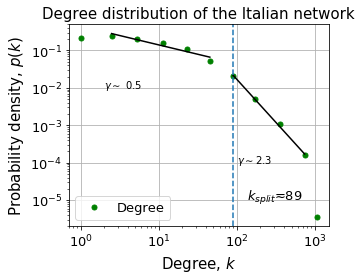

In [142]:
fig, ax = plt.subplots(figsize = FIGSIZE_ONECOL)
plt.plot(ita_degree_means, ita_degree_log_probs, 'o', color='green',   label='Degree', markersize = 5)

# barabasi
#plt.plot(ba_degree_means, ba_degree_log_probs, 'o', color='orange',   label='BA degree', markersize = 5)
#gamma_ba = regression(ba_degree_means, ba_degree_log_probs, 6, 12, color='orange').round(1)
#plt.text(1000,float(1)/100, "$\gamma_{BA}\sim $"+" {}".format(gamma_ba), color = 'orange')

split = 6
gamma_ita_1 = regression(ita_degree_means, ita_degree_log_probs, 1,split).round(1)
gamma_ita_2 = regression(ita_degree_means, ita_degree_log_probs, split, 10).round(1)
print gamma_ita_2

plt.text(2, (float(1)/100), "$\gamma \sim $ {}".format(gamma_ita_1))
plt.text(100,float(1)/10000, "$\gamma \sim $"+ "{}".format(gamma_ita_2))
# info on the splitting

degree_split = degree_means[split].round(0)
plt.axvline(degree_split, 0,1000, linestyle='--')
plt.text(1.5*degree_split, float(1)/10**5, "$k_{split} \eqsim$"+"{:.0f}".format(degree_split), fontsize=SMALL_SIZE)

plt.title("Degree distribution of the Italian network")
plt.xlabel("Degree, $k$")
plt.ylabel("Probability density, $p(k)$")                               
plt.loglog()
plt.grid()
plt.legend()
plt.tight_layout()
plt.savefig("imgs/tot_degree_distribution_ita.pdf")                                     


In [144]:
g_ita_info['gamma'] = round(gamma_ita_2,2)
g_ita_info

{'L': 71466,
 'N': 2333,
 'density': 0.01314,
 'gamma': 2.3,
 'k_avg': 30,
 'k_in_max': 961,
 'k_in_min': 0,
 'k_max': 1058,
 'k_min': 1,
 'k_out_max': 596,
 'k_out_min': 0}

In [145]:
times= []
start = datetime.datetime.now()
ita_distances = sample_distances(g_ita, 2500)
ita_distances_und = sample_distances(g_ita_und, 2500)

end = datetime.datetime.now()



avg distance: 2.78062678063
avg distance: 2.32745490982


In [146]:
d_mean_ita = np.mean(ita_distances)
d_std_ita = np.mean(ita_distances)/np.sqrt(len(ita_distances))
s_ita = np.std(ita_distances)

In [147]:
d_mean_ita_und = np.mean(ita_distances_und)

In [148]:
g_ita_info['avg_d'] = d_mean_ita
g_ita_und_info['avg_d'] = d_mean_ita_und

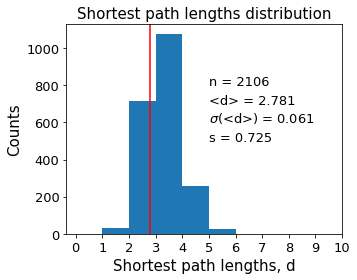

In [149]:
# average path length distribution
plt.subplots(figsize = FIGSIZE_ONECOL)
prova=plt.hist(ita_distances,bins = np.arange(0,8))
plt.title("Shortest path lengths distribution")
plt.xlabel("Shortest path lengths, d")
plt.ylabel("Counts")
plt.tight_layout()
plt.xticks(np.arange(max(ita_distances)+5))
plt.axvline(np.mean(ita_distances), color="red")
plt.text(5,800, "n = {:.0f}".format(len(ita_distances)), fontsize = SMALL_SIZE)
plt.text(5,700, "<d> = {:.3f}".format(d_mean_ita), fontsize =SMALL_SIZE)
plt.text(5,600, "$\sigma$"+"(<d>) = {:.3f}".format(d_std_ita),fontsize =SMALL_SIZE)
plt.text(5,500, "s = {:.3f}".format(s_ita),fontsize =SMALL_SIZE)
plt.savefig('./imgs/paths_hist_ita.pdf', format='pdf')

In [150]:
nodes_ita= [n for n,d in g_ita.in_degree()]
g_und_ita = g_ita.to_undirected()
clusters_ita = nx.clustering(g_und_ita, nodes_ita)

#clusters_ita

In [151]:
clust_ita = [clusters_ita[nd] for nd in nodes_ita]
#df_clust_ita = pd.DataFrame({'id':nodes_ita, 'C': clust_ita, 'degree' : deg})
#df_clust.head()


In [152]:
C_mean_ita = np.mean(clust_ita)
C_std_ita = np.std(clust_ita)
C_mean_std_ita = np.std(clust_ita)/np.sqrt(len(clust_ita))

In [162]:
g_ita_und_info['C_mean'] = C_mean_ita

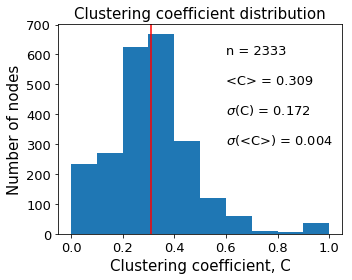

In [153]:
# clustering coef distribution
plt.subplots(figsize = FIGSIZE_ONECOL)
prova=plt.hist(clust_ita)
plt.title("Clustering coefficient distribution")
plt.xlabel("Clustering coefficient, C")
plt.ylabel("Number of nodes")
plt.tight_layout()
#plt.xticks(np.arange(max(clust)+0.1))
plt.axvline(np.mean(clust_ita), color="red")
xpos = 0.6
plt.text(xpos,600, "n = {:.0f}".format(len(clust_ita)), fontsize =SMALL_SIZE)
plt.text(xpos,500, "<C> = {:.3f}".format(C_mean_ita), fontsize = SMALL_SIZE)
plt.text(xpos,400, "$\sigma$"+"(C) = {:.3f}".format(C_std_ita), fontsize = SMALL_SIZE)
plt.text(xpos,300, "$\sigma$"+"(<C>) = {:.3f}".format(C_mean_std_ita) , fontsize =SMALL_SIZE)
plt.savefig('./imgs/cluster_coef_hist_ita.pdf', format='pdf')


In [154]:
g_ita_und_info['C_avg'] = C_mean_ita

Triangles

In [196]:
start = datetime.datetime.now()
triangles_ita = nx.triangles(g_und_ita)
end = datetime.datetime.now()
print (end-start).seconds 

3


In [199]:
Tlist_ita = (triangles_ita.values())
T_ita = (sum(Tlist_ita))/3
g_ita_und_info['T'] = T_ita


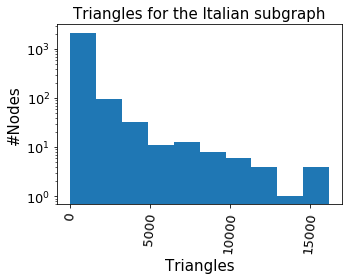

In [201]:
plt.subplots(figsize = FIGSIZE_ONECOL)
plt.hist(sorted(triangles_ita.values()), log=True)
plt.title('Triangles for the Italian subgraph')
plt.xlabel('Triangles')
plt.ylabel('#Nodes')
plt.xticks(rotation=85)
plt.tight_layout()
plt.savefig('./imgs/triangles_tot_ita.pdf', format='pdf')


# Infos summary

In [236]:
index = list(set(g_info.keys()) | set(g_er_info.keys()) | set(g_und_info))
info = pd.DataFrame( index= index, columns = ['g', 'g_und', 'g_er', 'g_ba','g_ita','g_ita_und'])

In [237]:
for i in index:
    info['g'][i] = g_info.get(i)
    info['g_und'][i] = g_und_info.get(i)
    info['g_ba'][i] = g_ba_info.get(i)
    info['g_er'][i] = g_er_info.get(i)
    info['g_ita'][i] = g_ita_info.get(i)
    info['g_ita_und'][i] = g_ita_und_info.get(i)
    

In [238]:
info

                 g     g_und        g_er        g_ba    g_ita g_ita_und
k_in_min         0      None          36        None        0      None
k_in_max     19064      None         109        None      961      None
L          2501757   1895878     4318406     2496258    71466     55594
k_out_min        0      None          35        None        0      None
N            65729     65729       65729       65729     2333      2333
T             None  22765186      376972      996837     None    416232
k_min            1         1          84          38        1         1
C_mean        None  0.253731  0.00199506  0.00671877     None  0.308587
avg_d         None   2.92118     2.95121     2.83379  2.78063   2.32745
density    0.00058   0.00088       0.001     0.00116  0.01314   0.02044
k_out_max     4130      None         103        None      596      None
k_max        19073     19065         183        2890     1058       963
gamma_out      2.9      None        None        None     None   

In [239]:
with open('../../report/statistics.tex','w') as f:
    f.write(info.to_latex())